# Predicting Starcraft 2 players
[Kaggle Starcraft II Prediction Challenge](https://www.kaggle.com/c/insa-5if-2018)

## Initialisation
We will use Python3 with [Numpy](http://www.numpy.org/) for linear algebra, [Pandas](https://pandas.pydata.org/) for data processing and CSV files I/O, and [scikit-learn](https://scikit-learn.org/stable/) for predictions. The environment is defined by the [Kaggle Python docker image](https://github.com/kaggle/docker-python).

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import neighbors
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
pd.set_option('display.max_colwidth', 200)

## Reading data
Let's define some functions to read data from the CSV files. We are storing an array of actions for each line.

In [2]:
def read_train(file):
    ids = []
    data = []
    with open(file,'r') as f:
        for line in f:
            line_data = line.replace('\n','').split(',')
            battlenet_id, race, actions = line_data[0],line_data[1],line_data[2:]
            ids.append(battlenet_id)
            data.append([race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['race','actions'])
    series = pd.Series(ids)
    return df, series

def read_test(file):
    data = []
    with open(file,'r') as f:
        for line in f:
            line_data = line.replace('\n','').split(',')
            race, actions = line_data[0],line_data[1:]
            data.append([race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['race','actions'])
    return df
        

Input data files are available in the `../input/` directory.
Any results written to the current directory are saved as output.

In [3]:
folder = '../'
train_data, train_ids = read_train(folder + 'TRAIN.CSV')
train_data.head()

,race,actions
0,Protoss,"Base, s, s, s, s, s, t5, Base, s, hotkey30, hotkey00, t10, t15, t20, t25, t30, t35, s, hotkey32, s, hotkey32, s, hotkey32, s, t40, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, t45, hotkey32..."
1,Protoss,"s, Base, s, s, Base, s, s, Base, s, t5, hotkey30, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t10, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t15, s, hot..."
2,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5, t10, t15, s, hotkey32, s, hotkey32, s, hotkey32, s, t20, hotkey32, s, s, hotkey32, s, hotkey32, t25, s, hotkey32, s, hotkey32, s, hotkey32, s, hotke..."
3,Protoss,"Base, s, s, Base, s, s, s, t5, Base, s, hotkey30, s, hotkey32, s, hotkey32, t10, s, hotkey32, s, hotkey32, t15, s, hotkey32, s, t20, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t25, s, hotkey..."
4,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5, t10, t15, s, hotkey32, s, hotkey32, s, hotkey32, t20, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, t25, hotkey32, t30, s, hot..."


In [4]:
train_ids.head()

0       http://eu.battle.net/sc2/en/profile/4234852/1/First/
1    http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/
2       http://eu.battle.net/sc2/en/profile/4234852/1/First/
3    http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/
4       http://eu.battle.net/sc2/en/profile/4234852/1/First/
dtype: object

In [5]:
test_data = read_test(folder + 'TEST.CSV')
test_data.head()

,race,actions
0,Zerg,"s, s, s, hotkey10, s, hotkey60, s, hotkey00, s, hotkey90, t5, hotkey02, s, hotkey02, hotkey62, hotkey02, s, hotkey02, hotkey62, hotkey02, hotkey62, s, hotkey02, hotkey62, s, hotkey62, hotkey02, ho..."
1,Terran,"s, hotkey30, hotkey00, t5, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t10, s, hotke..."
2,Protoss,"Base, s, s, Base, s, hotkey20, hotkey30, hotkey60, hotkey40, hotkey80, hotkey70, s, hotkey62, s, hotkey62, t5, s, hotkey62, s, hotkey20, hotkey62, hotkey22, hotkey62, s, hotkey62, s, hotkey62, hot..."
3,Zerg,"s, s, s, s, hotkey20, s, hotkey40, t5, t10, hotkey22, hotkey42, s, hotkey42, s, t15, s, s, s, hotkey42, s, hotkey42, hotkey22, hotkey42, hotkey22, hotkey42, t20, s, hotkey42, s, hotkey42, s, hotke..."
4,Protoss,"Base, s, s, Base, s, hotkey50, hotkey30, t5, hotkey40, s, t10, hotkey52, t15, s, t20, hotkey52, t25, s, hotkey52, s, hotkey52, s, hotkey52, s, hotkey52, s, hotkey52, s, hotkey52, s, hotkey52, s, h..."


## First look at the data

### Race repartition

In [6]:
races = train_data['race'].value_counts()
print(races)
plt = races.plot.bar()

Protoss    1210
Zerg       1061
Terran      781
Name: race, dtype: int64


### Number of games by player

In [7]:
ids = train_ids.value_counts()
print(ids.describe())

count    200.00000
mean      15.26000
std       10.41464
min        4.00000
25%        7.00000
50%       12.00000
75%       20.00000
max       58.00000
dtype: float64


### List of actions (hotkeys)

In [8]:
def find_unique_actions(df):
    unique_actions = set()
    actions = df['actions']
    for action in actions:
        for a in action.split(','):
            a = a.strip()
            if a!='' and a[0]!='t':
                unique_actions.add(a)
    return unique_actions

unique_hotkeys = sorted(list(find_unique_actions(train_data)))
print(unique_hotkeys)

keys = list(set([hotkey[:len(hotkey)-1] for hotkey in unique_hotkeys if 'hotkey' in hotkey]))
print(keys)
    

['Base', 'SingleMineral', 'hotkey00', 'hotkey01', 'hotkey02', 'hotkey10', 'hotkey11', 'hotkey12', 'hotkey20', 'hotkey21', 'hotkey22', 'hotkey30', 'hotkey31', 'hotkey32', 'hotkey40', 'hotkey41', 'hotkey42', 'hotkey50', 'hotkey51', 'hotkey52', 'hotkey60', 'hotkey61', 'hotkey62', 'hotkey70', 'hotkey71', 'hotkey72', 'hotkey80', 'hotkey81', 'hotkey82', 'hotkey90', 'hotkey91', 'hotkey92', 's']
['hotkey8', 'hotkey4', 'hotkey0', 'hotkey3', 'hotkey6', 'hotkey9', 'hotkey5', 'hotkey1', 'hotkey7', 'hotkey2']


## Defining features
We are defining features as the race and the number of clicks on the hotkeys in the first 10 seconds. We have 
Let's try this approach by writing a function to generate those features.

We use Dummy variables to convert the race string into integers values.

In [9]:
hotkey_columns = ['first_hotkey','second_hotkey','third_hotkey','fourth_hotkey','fifth_hotkey','sixth_hotkey','seventh_hotkey','eighth_hotkey']

le = preprocessing.LabelEncoder()
def count_races(ids, df):
    players = {}
    for index, row in df.iterrows():
        race = row["race"]
        player = ids.get(index)
        if player not in players:
            players[player]={'Terran':0,'Protoss':0,'Zerg':0}
        players[player][race]+=1
    array_results = []
    for pl in players:
        array_results.append([pl, players[pl]['Terran'],players[pl]['Protoss'],players[pl]['Zerg']])
    results = pd.DataFrame(array_results, columns=['player', 'count_terran', 'count_protoss', 'count_zerg'])
    return results
    
    

def generate_features(df):
    features = []
    hotkeys = unique_hotkeys
    set_hotkeys = set(hotkeys)
    for index, row in df.iterrows():
        first_hotkeys = []
        race = row["race"]
        actions = row["actions"]
        hotkeys_count = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t30 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t60 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t90 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t120 = {hotkey:0 for hotkey in hotkeys}
        t30 = False
        t60 = False
        t90 = False
        t120 = False
        keys_count = {key:0 for key in keys}
        for action in actions.split(','):
            action = action.strip()
            if action in set_hotkeys:
                hotkeys_count[action]+=1
                if not t30:
                    hotkeys_count_t30[action]+=1
                if not t60:
                    hotkeys_count_t60[action]+=1
                if not t90:
                    hotkeys_count_t90[action]+=1
                if not t90:
                    hotkeys_count_t120[action]+=1
            if 'hotkey' in action:
                keys_count[action[:len(action)-1]]+=1
            if len(first_hotkeys)<len(hotkey_columns) and 'hotkey' in action:
                first_hotkeys.append(action)
                
            if 't30' in action:
                t30 = False
            elif 't60' in action:
                t60 = True
            elif 't90' in action:
                t90 = True
            elif 't120' in action:
                t120 = True
                
        while len(first_hotkeys)<len(hotkey_columns):
            first_hotkeys.append('None')
        current = [race, *[hotkeys_count[hotkey] for hotkey in hotkeys],*[hotkeys_count_t30[hotkey] for hotkey in hotkeys],*[hotkeys_count_t60[hotkey] for hotkey in hotkeys],*[hotkeys_count_t90[hotkey] for hotkey in hotkeys], *[hotkeys_count_t120[hotkey] for hotkey in hotkeys], *[keys_count[key] for key in keys], *first_hotkeys]
        features.append(current)
    new_df = pd.DataFrame(features, columns=['race', *hotkeys,*[hotkey+'_t30' for hotkey in hotkeys],*[hotkey+'_t60' for hotkey in hotkeys],*[hotkey+'_t90' for hotkey in hotkeys],*[hotkey+'_t120' for hotkey in hotkeys], *keys, *hotkey_columns])
    return new_df

In [10]:
train_features = generate_features(train_data)
for col in hotkey_columns:
    train_features[col] = le.fit_transform(train_features[col]) 
train_features.columns.values

array(['race', 'Base', 'SingleMineral', 'hotkey00', 'hotkey01',
       'hotkey02', 'hotkey10', 'hotkey11', 'hotkey12', 'hotkey20',
       'hotkey21', 'hotkey22', 'hotkey30', 'hotkey31', 'hotkey32',
       'hotkey40', 'hotkey41', 'hotkey42', 'hotkey50', 'hotkey51',
       'hotkey52', 'hotkey60', 'hotkey61', 'hotkey62', 'hotkey70',
       'hotkey71', 'hotkey72', 'hotkey80', 'hotkey81', 'hotkey82',
       'hotkey90', 'hotkey91', 'hotkey92', 's', 'Base_t30',
       'SingleMineral_t30', 'hotkey00_t30', 'hotkey01_t30',
       'hotkey02_t30', 'hotkey10_t30', 'hotkey11_t30', 'hotkey12_t30',
       'hotkey20_t30', 'hotkey21_t30', 'hotkey22_t30', 'hotkey30_t30',
       'hotkey31_t30', 'hotkey32_t30', 'hotkey40_t30', 'hotkey41_t30',
       'hotkey42_t30', 'hotkey50_t30', 'hotkey51_t30', 'hotkey52_t30',
       'hotkey60_t30', 'hotkey61_t30', 'hotkey62_t30', 'hotkey70_t30',
       'hotkey71_t30', 'hotkey72_t30', 'hotkey80_t30', 'hotkey81_t30',
       'hotkey82_t30', 'hotkey90_t30', 'hotkey91_t30', 

In [11]:
count_player_races = count_races(train_ids, train_features)

def check_unique_race(df):
    player_races = {}
    ok = 0
    terran = 0
    zerg = 0
    protoss = 0
    
    for index, row in df.iterrows():
        player = row['player']
        count_terran = row['count_terran']
        count_zerg = row['count_zerg']
        count_protoss = row['count_protoss']
        if (count_terran and count_protoss) or (count_terran and count_zerg) or (count_zerg and count_protoss):
            print(player)
        else:
            ok+=1
        
        if count_terran:
            terran+=1
            player_races[player]='Terran'
        elif count_protoss:
            protoss+=1
            player_races[player]='Protoss'
        else:
            zerg+=1
            player_races[player]='Zerg'
    print('Terran: ' + str(terran) + ', Zerg: ' + str(zerg) + ', Protoss: ' + str(protoss))
    return ok, terran, zerg, protoss, player_races

ok, terran, zerg, protoss, player_races = check_unique_race(count_player_races)   

Terran: 55, Zerg: 71, Protoss: 74


In [12]:
races = train_features['race'] 

colors_terran = cm.rainbow(np.linspace(0, 1, terran))
colors_zerg = cm.rainbow(np.linspace(0, 1, zerg))
colors_protoss = cm.rainbow(np.linspace(0, 1, protoss))

ids_colors = {}
id_terran, id_zerg, id_protoss = 0,0,0
for player_id, race in player_races.items():
    if race == 'Terran':
        ids_colors[player_id] = colors_terran[id_terran]
        id_terran+=1
    elif race == 'Protoss':
        ids_colors[player_id] = colors_protoss[id_protoss]
        id_protoss+=1
    elif race == 'Zerg':
        ids_colors[player_id] = colors_zerg[id_zerg]
        id_zerg+=1

train_features['race'] = le.fit_transform(train_features['race']) 
print(list(le.classes_))
race_symbols = {}
markers = ['D', 'o','*']
for marker, race in zip(markers, train_features['race'].unique()):
    race_symbols[race] = marker

['Protoss', 'Terran', 'Zerg']


In [13]:
x_train, x_test, y_train, y_test = train_test_split(train_features, train_ids, test_size=0.30, random_state=42)
target_names = train_ids.unique()

In [14]:
pca = PCA(n_components=2)
x_features_pca = pca.fit_transform(train_features)
x_train_pca = pca.transform(x_train)
x_train_pca.shape

x_test_pca = pca.transform(x_test)


In [15]:
K_list = {1:[], 2:[], 3:[], 5:[], 10:[]}
D_list = [2, 3, 4, 5, 8, 10, 15, 20, 30, 40, 50]

for d in D_list:
    pca = PCA(n_components=d)
    x_features_pca = pca.fit_transform(train_features)
    x_train_pca = pca.transform(x_train)
    x_train_pca.shape

    x_test_pca = pca.transform(x_test)

    
    for k in K_list:
        clf = neighbors.KNeighborsClassifier(k, weights='distance')
        clf.fit(x_train_pca, y_train)
        y_predict_knn = clf.predict(x_test_pca)
        K_list[k].append(f1_score(y_test, y_predict_knn, average='micro'))

    

In [16]:
K_list

{1: [0.08624454148471616,
  0.21397379912663755,
  0.37336244541484714,
  0.5087336244541485,
  0.6637554585152838,
  0.6877729257641921,
  0.720524017467249,
  0.7390829694323144,
  0.740174672489083,
  0.74235807860262,
  0.74235807860262],
 2: [0.08624454148471616,
  0.21397379912663755,
  0.37336244541484714,
  0.5087336244541485,
  0.6637554585152838,
  0.6877729257641921,
  0.720524017467249,
  0.7390829694323144,
  0.740174672489083,
  0.74235807860262,
  0.74235807860262],
 3: [0.0927947598253275,
  0.22707423580786026,
  0.388646288209607,
  0.5163755458515283,
  0.6539301310043668,
  0.6724890829694323,
  0.6975982532751092,
  0.7074235807860262,
  0.7139737991266377,
  0.7150655021834061,
  0.7161572052401747],
 5: [0.09497816593886463,
  0.2336244541484716,
  0.3962882096069869,
  0.50764192139738,
  0.6397379912663755,
  0.6539301310043668,
  0.6943231441048034,
  0.7008733624454149,
  0.7063318777292577,
  0.7074235807860262,
  0.7074235807860262],
 10: [0.099344978165938

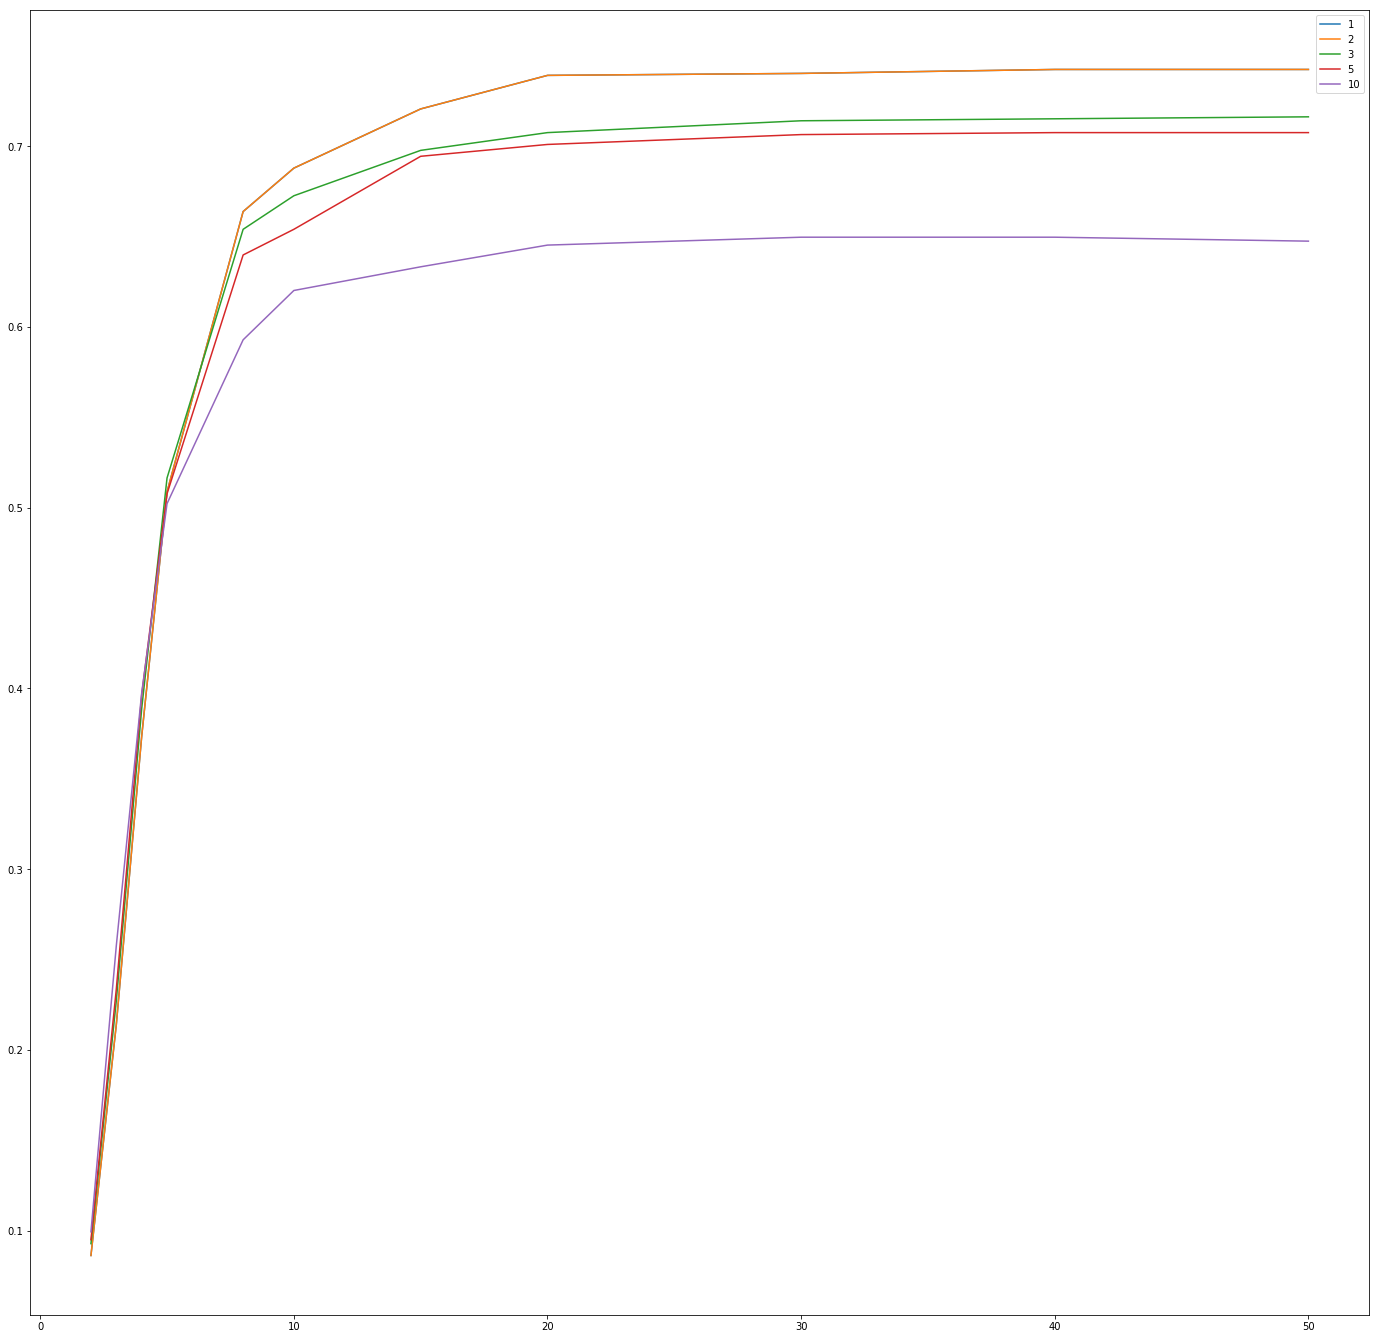

In [17]:
f1_score_knn = pd.DataFrame(K_list, index=D_list)
lines = f1_score_knn.plot.line(figsize=(24,24))

In [18]:
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(x_train_pca, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

In [19]:
y_predict_knn = clf.predict(x_test_pca)
f1_score(y_test, y_predict_knn, average='micro')

0.7161572052401747

In [20]:
tsne = TSNE(n_components=2)
x_embedded = tsne.fit_transform(x_features_pca)
x_embedded.shape


(3052, 2)

In [21]:
pd_x_embedded = pd.DataFrame(x_embedded)
pd_x_embedded = pd_x_embedded.rename(index=str, columns={0: "x", 1: "y"})


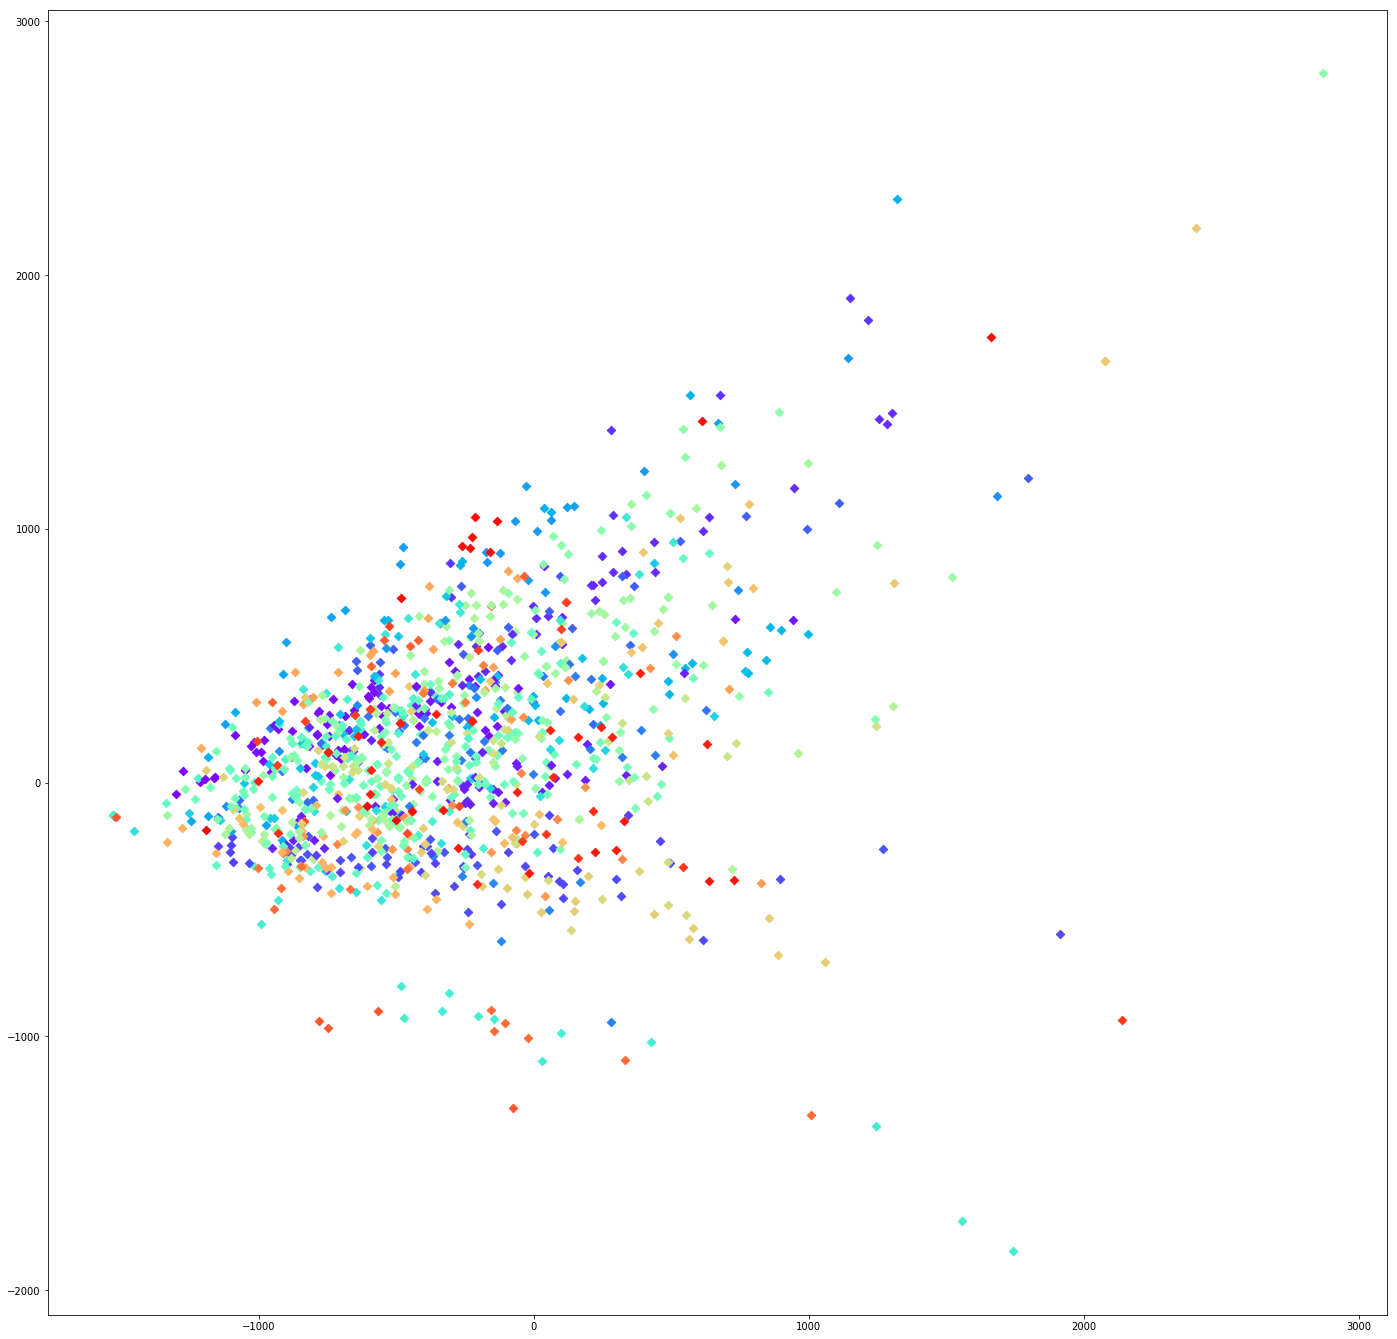

In [22]:
import matplotlib.pyplot as plt
races = train_features['race']

fig = plt.figure(figsize=(24,24))
races_unique = train_features['race'].unique()
idx_race = 0
for player, race, coor in zip(train_ids, races, x_features_pca): 
    if race == races_unique[idx_race]:
        plt.scatter(coor[0], coor[1], marker=race_symbols[race], color=ids_colors[player])

plt.show()

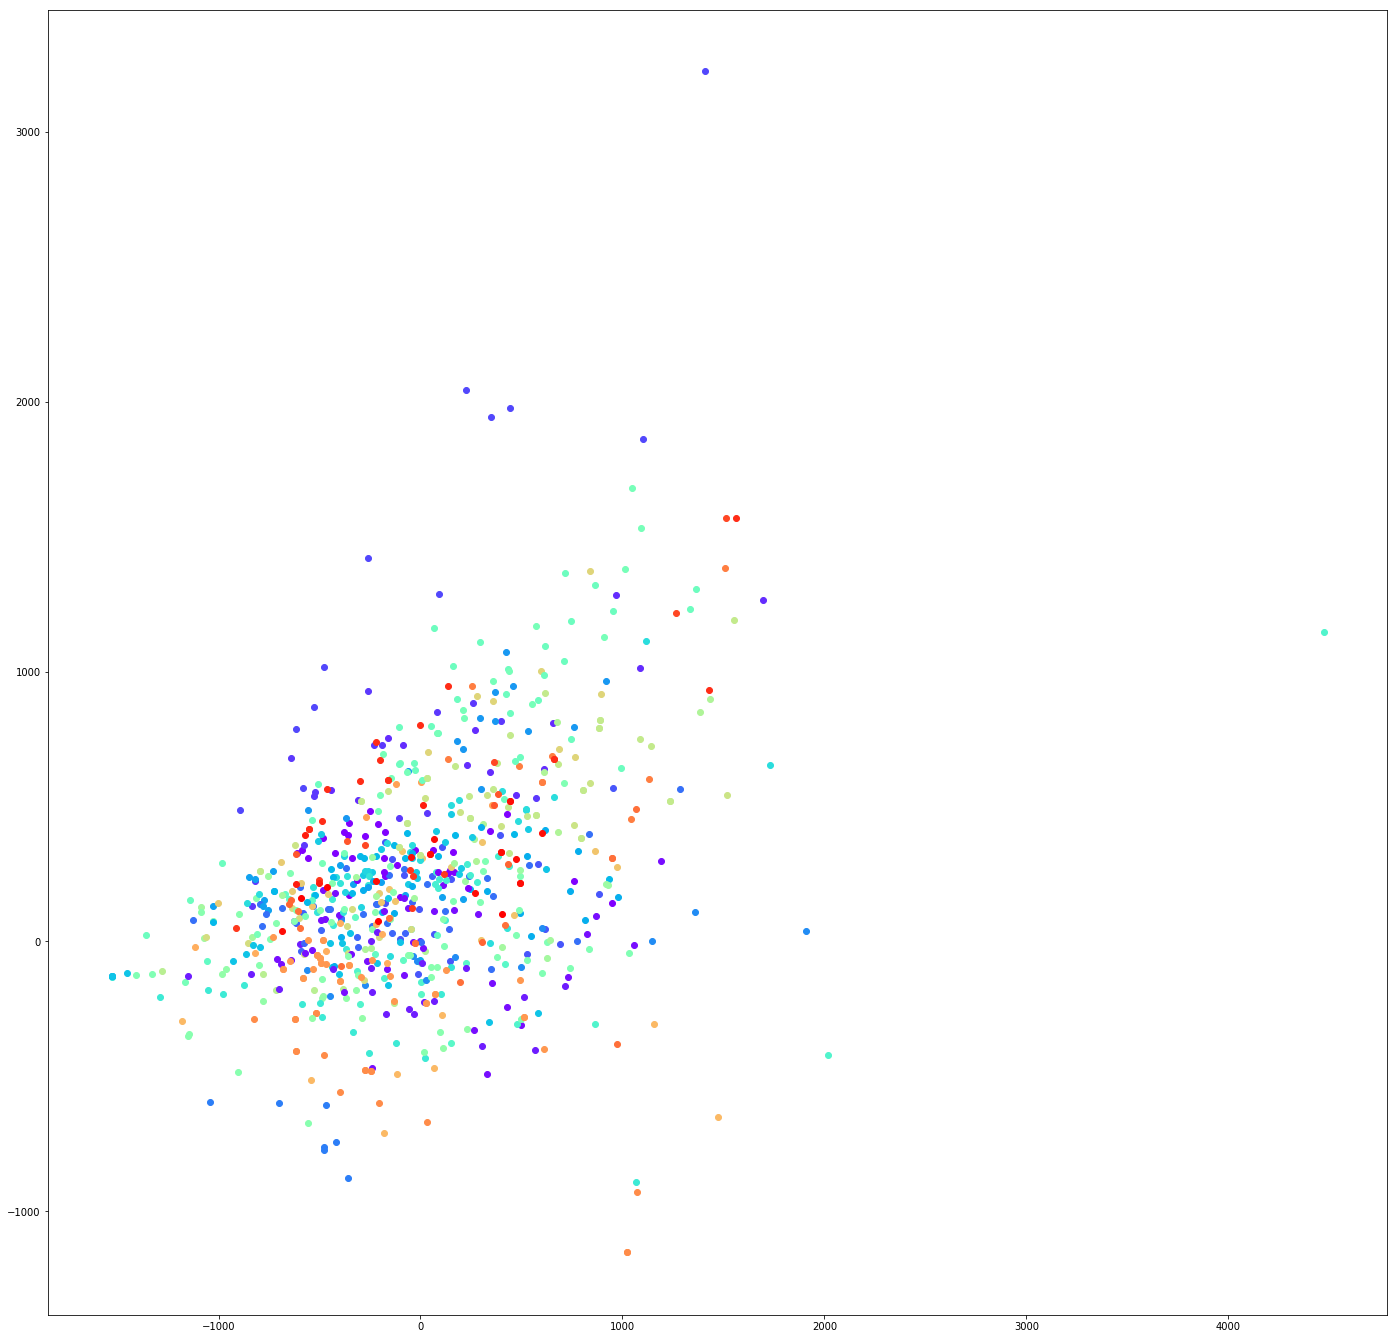

In [23]:
fig = plt.figure(figsize=(24,24))
idx_race = 1
for player, race, coor in zip(train_ids, races, x_features_pca): 
    if race == races_unique[idx_race]:
        plt.scatter(coor[0], coor[1], marker=race_symbols[race], color=ids_colors[player])

plt.show()

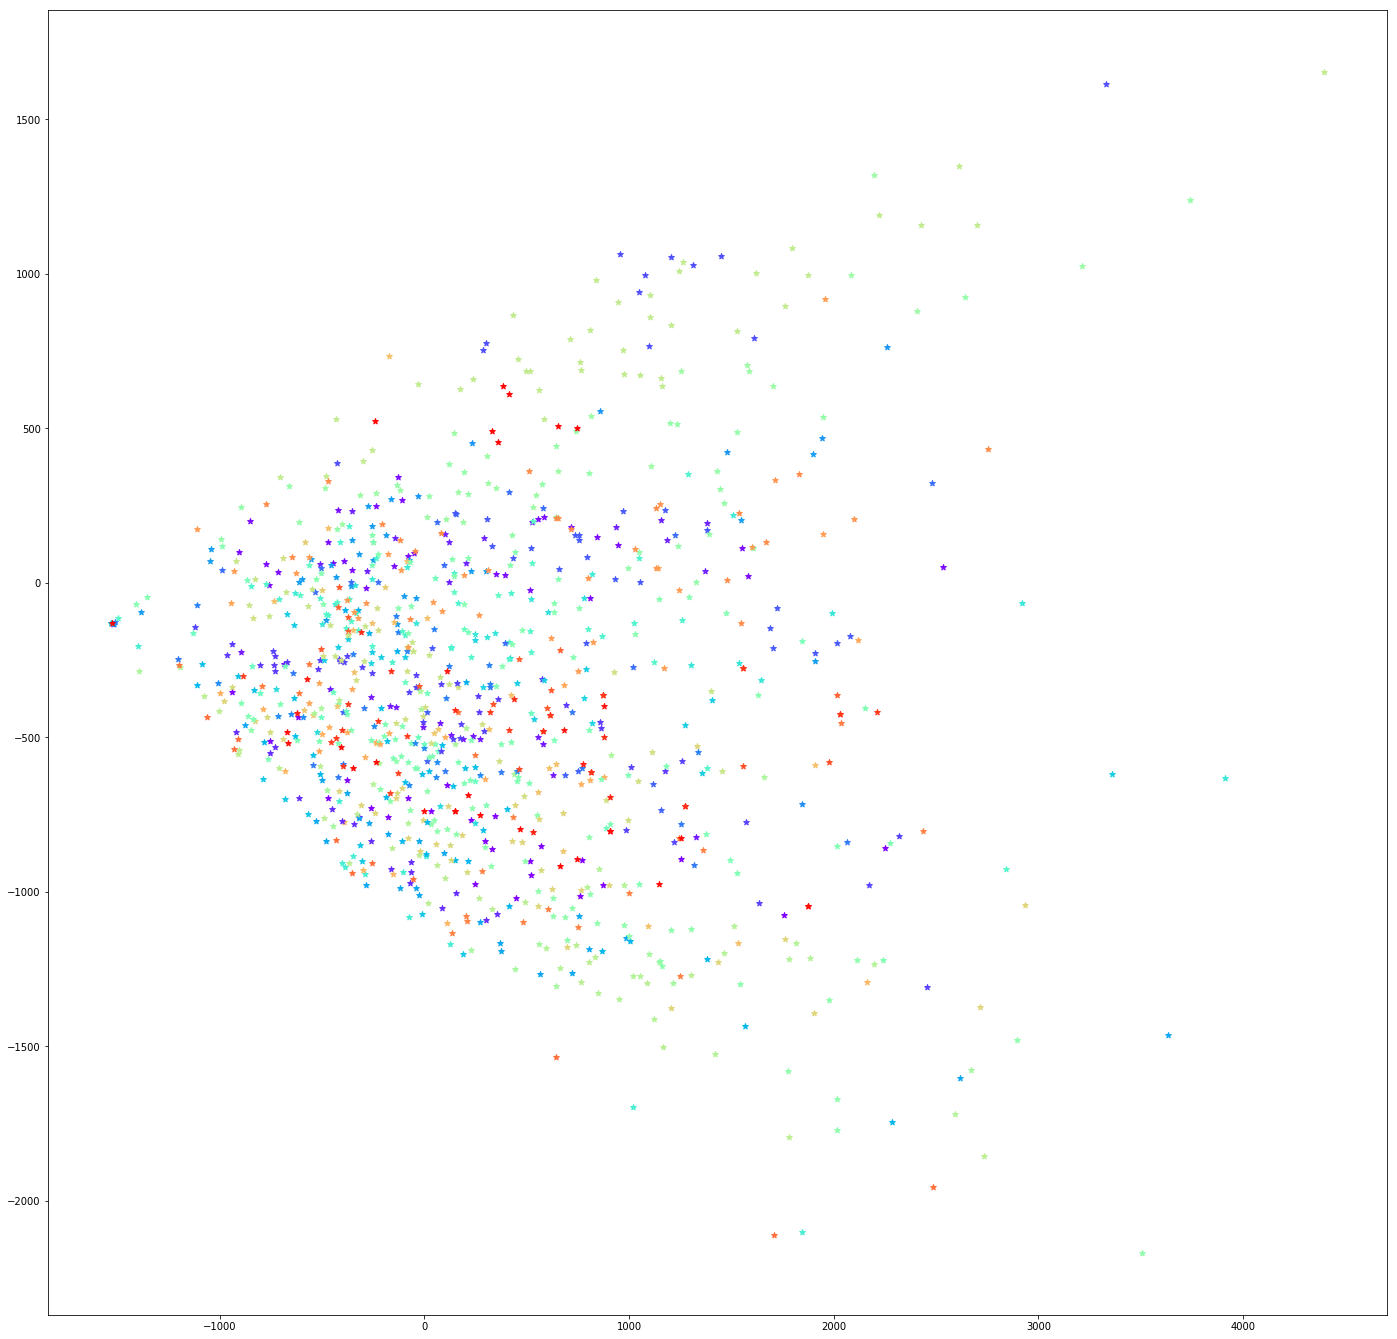

In [24]:
fig = plt.figure(figsize=(24,24))
idx_race = 2
for player, race, coor in zip(train_ids, races, x_features_pca): 
    if race == races_unique[idx_race]:
        plt.scatter(coor[0], coor[1], marker=race_symbols[race], color=ids_colors[player])

plt.show()

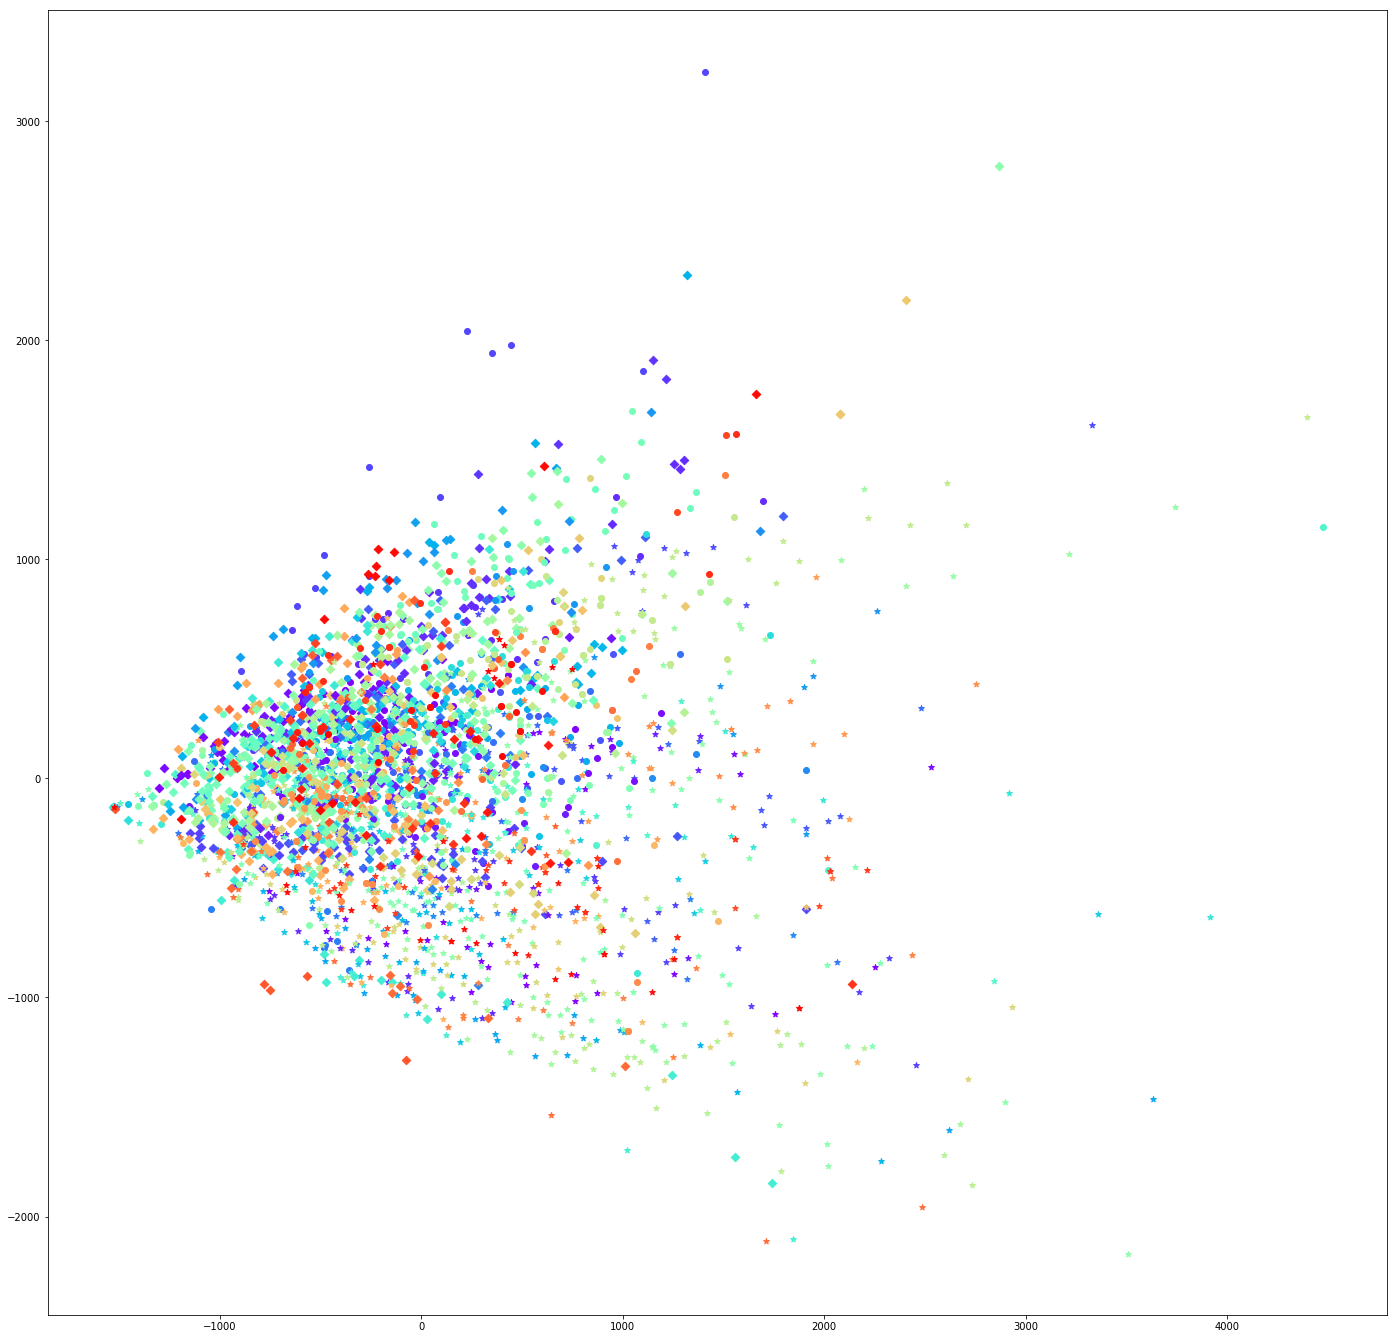

In [25]:
fig = plt.figure(figsize=(24,24))
for player, race, coor in zip(train_ids, races, x_features_pca): 
    plt.scatter(coor[0], coor[1], marker=race_symbols[race], color=ids_colors[player])

plt.show()

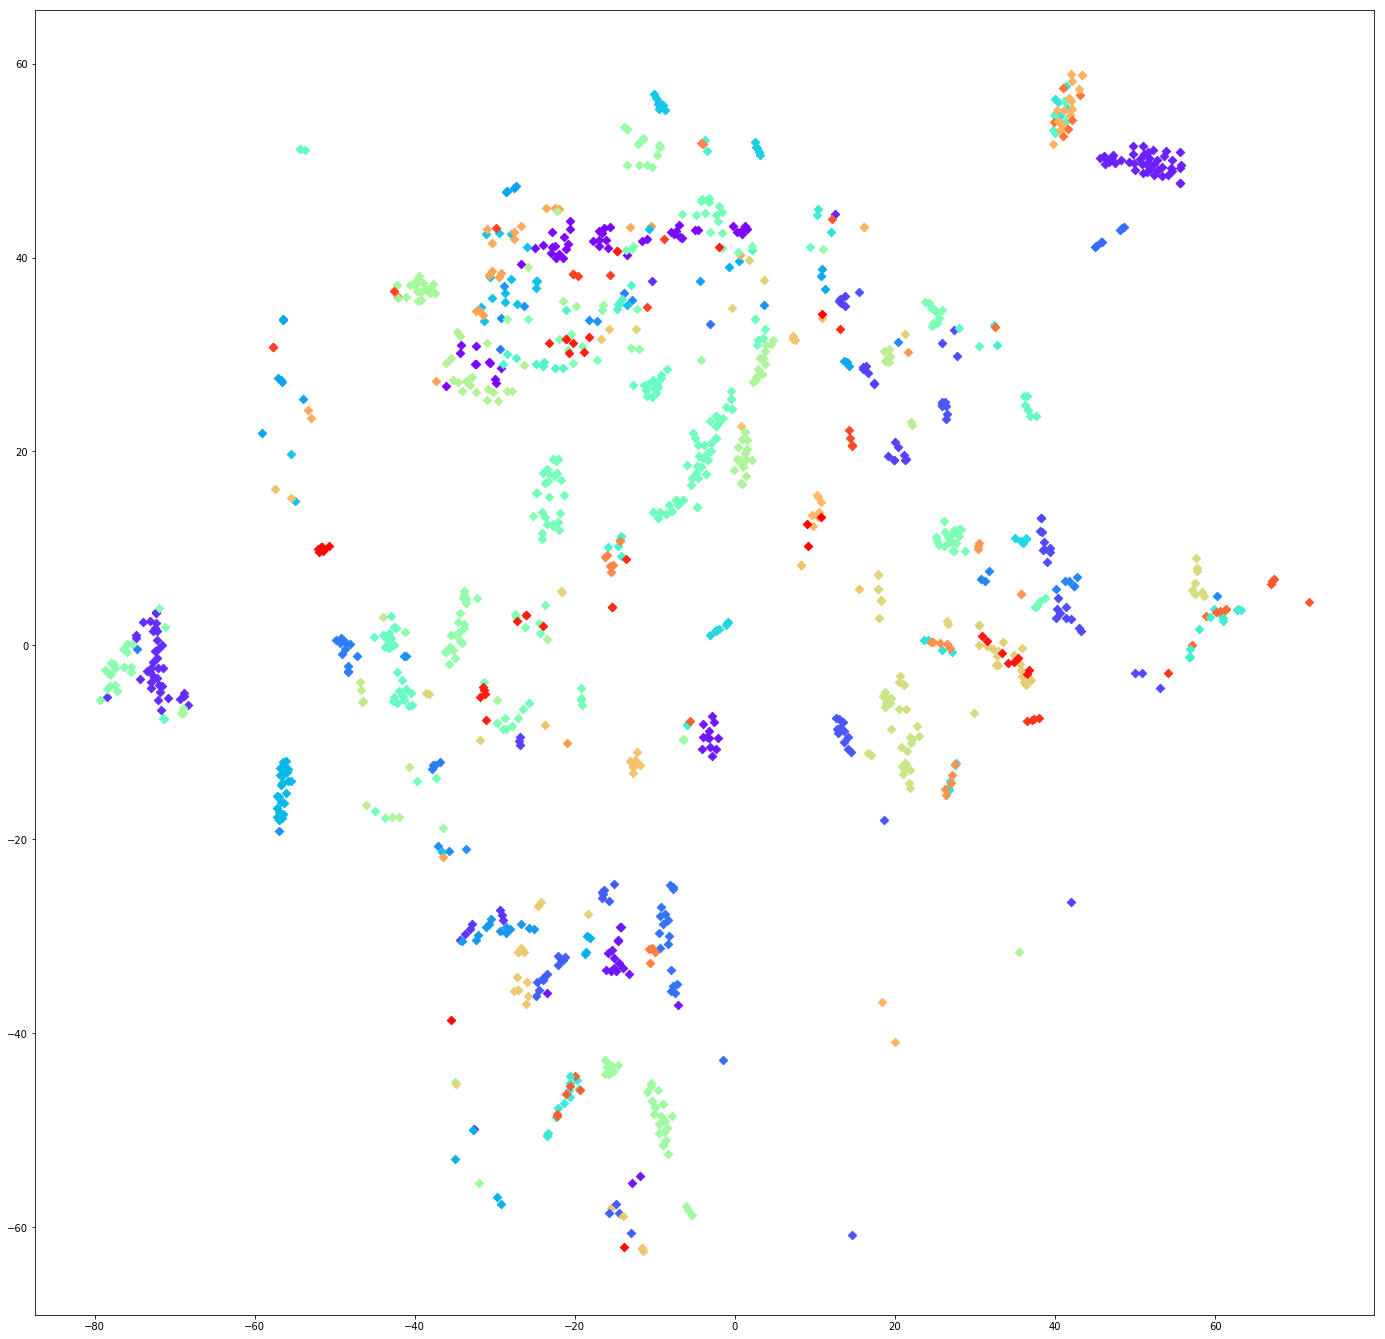

In [26]:
import matplotlib.pyplot as plt
x_feature = pd_x_embedded['x']
y_feature = pd_x_embedded['y']
races = train_features['race']

fig = plt.figure(figsize=(24,24))
races_unique = train_features['race'].unique()
idx_race = 0
for player, race, x, y in zip(train_ids, races, x_feature, y_feature): 
    if race == races_unique[idx_race]:
        plt.scatter(x, y, marker=race_symbols[race], color=ids_colors[player])

plt.show()

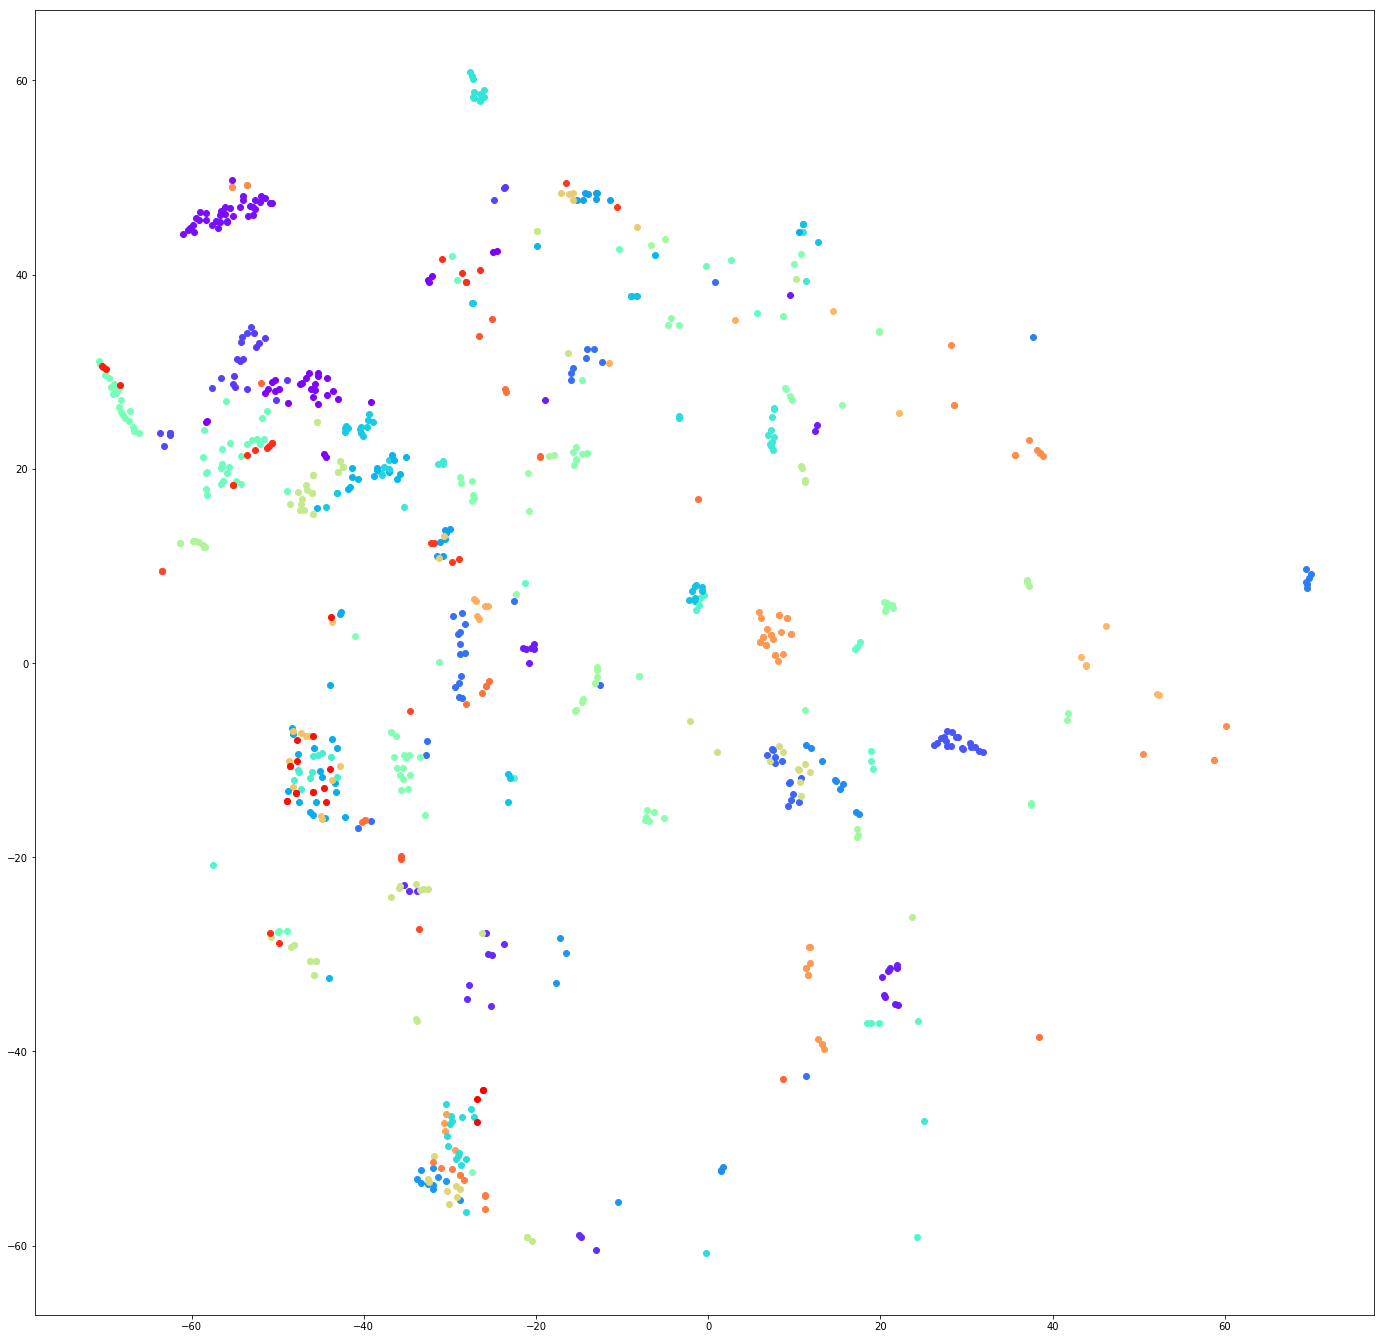

In [27]:
fig = plt.figure(figsize=(24,24))
idx_race = 1
for player, race, x, y in zip(train_ids, races, x_feature, y_feature): 
    if race == races_unique[idx_race]:
        plt.scatter(x, y, marker=race_symbols[race], color=ids_colors[player])

plt.show()

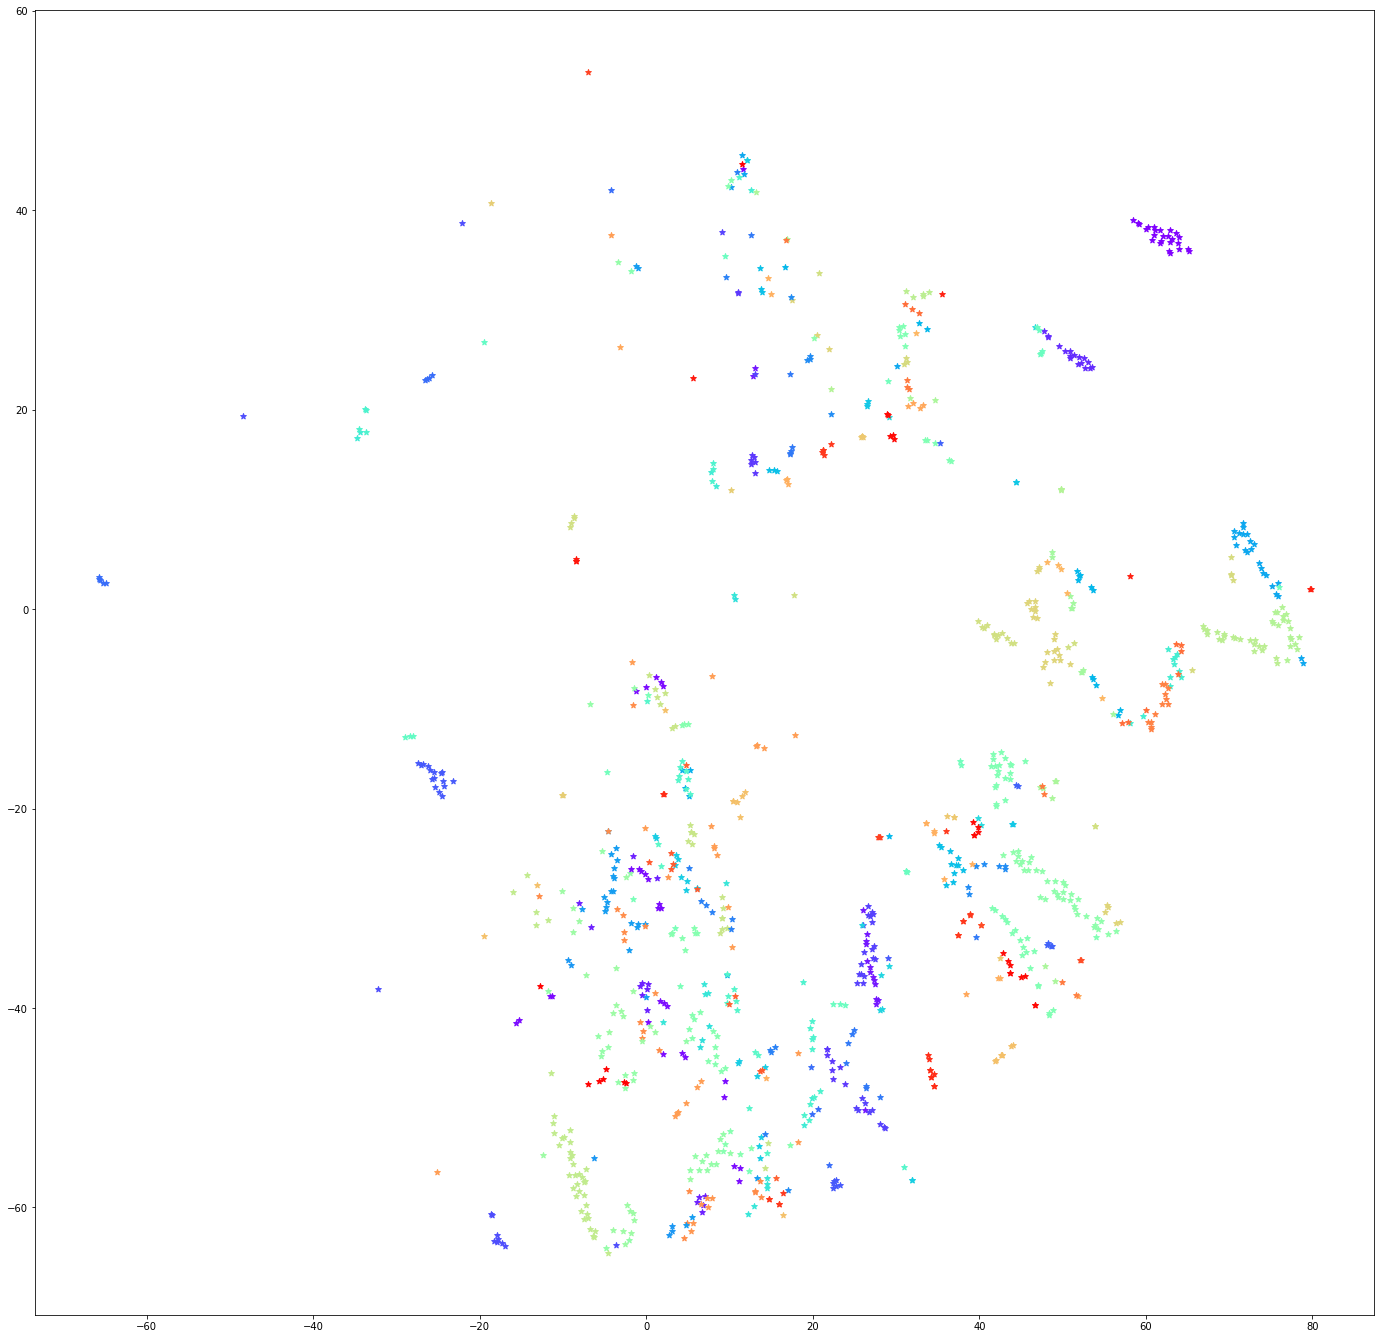

In [28]:
fig = plt.figure(figsize=(24,24))
idx_race = 2
for player, race, x, y in zip(train_ids, races, x_feature, y_feature): 
    if race == races_unique[idx_race]:
        plt.scatter(x, y, marker=race_symbols[race], color=ids_colors[player])

plt.show()

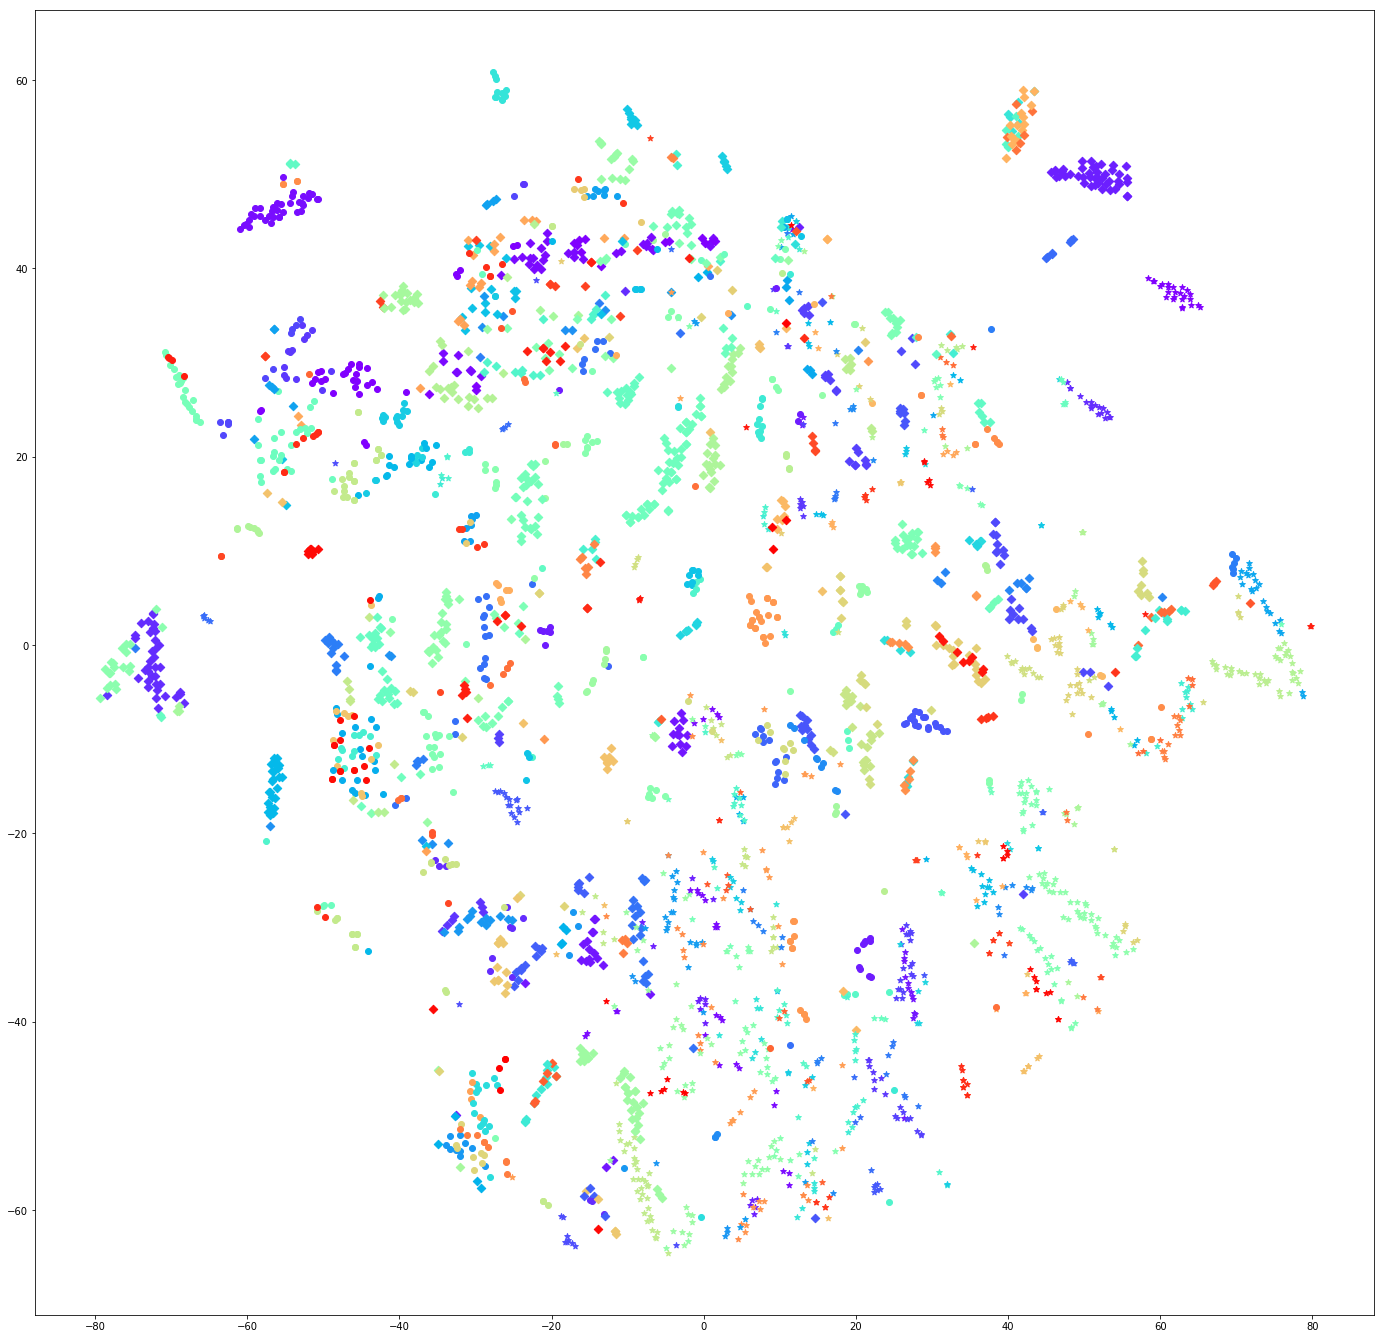

In [29]:
fig = plt.figure(figsize=(24,24))
for player, race, x, y in zip(train_ids, races, x_feature, y_feature): 
    plt.scatter(x, y, marker=race_symbols[race], color=ids_colors[player])

plt.show()

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


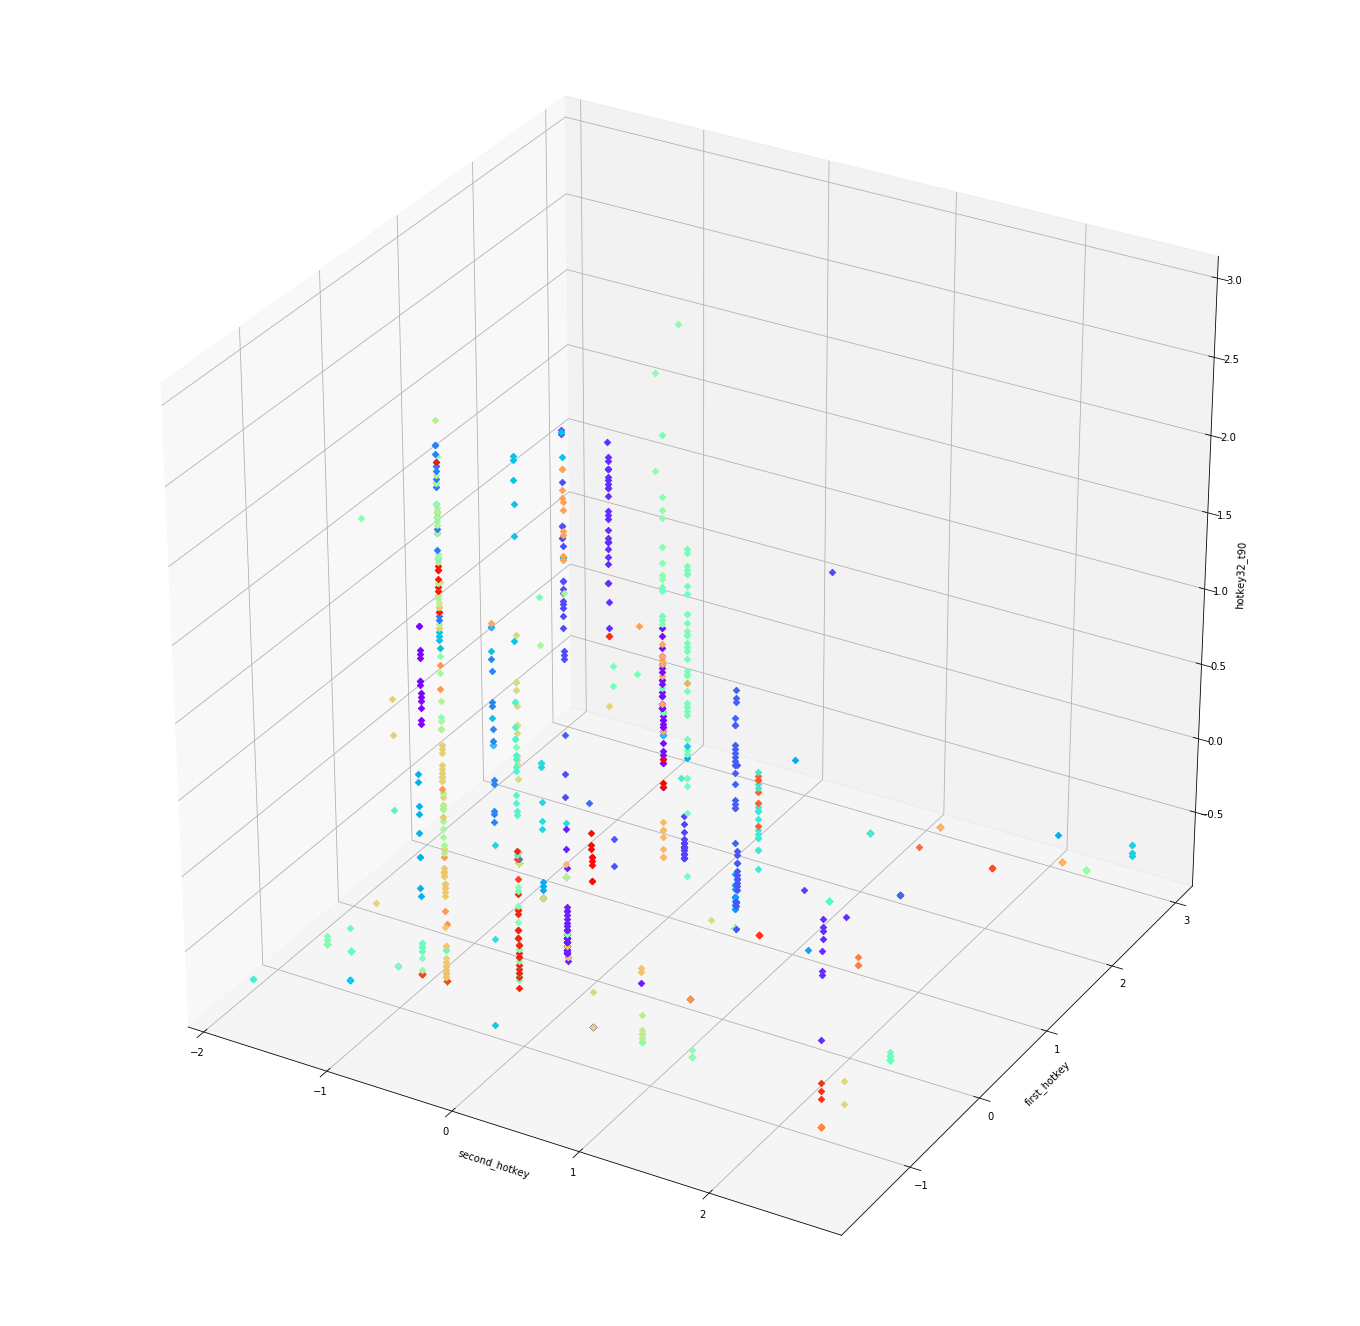

In [30]:
import matplotlib.pyplot as plt
x_feature = preprocessing.scale(train_features['second_hotkey'])
y_feature = preprocessing.scale(train_features['first_hotkey'])
z_feature = preprocessing.scale(train_features['hotkey32_t90'])
#le = preprocessing.LabelEncoder()
#le.fit(train_features['race'])
races = train_features['race'] 
colors = cm.rainbow(np.linspace(0, 1, train_ids.nunique()))
    
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('second_hotkey')
ax.set_ylabel('first_hotkey')
ax.set_zlabel('hotkey32_t90')

idx_race = 0
for player, race, x, y, z in zip(train_ids, races, x_feature, y_feature, z_feature): 
    if race == races_unique[idx_race]:
        ax.scatter(x, y, z, marker=race_symbols[race], color=ids_colors[player])
    
plt.show()

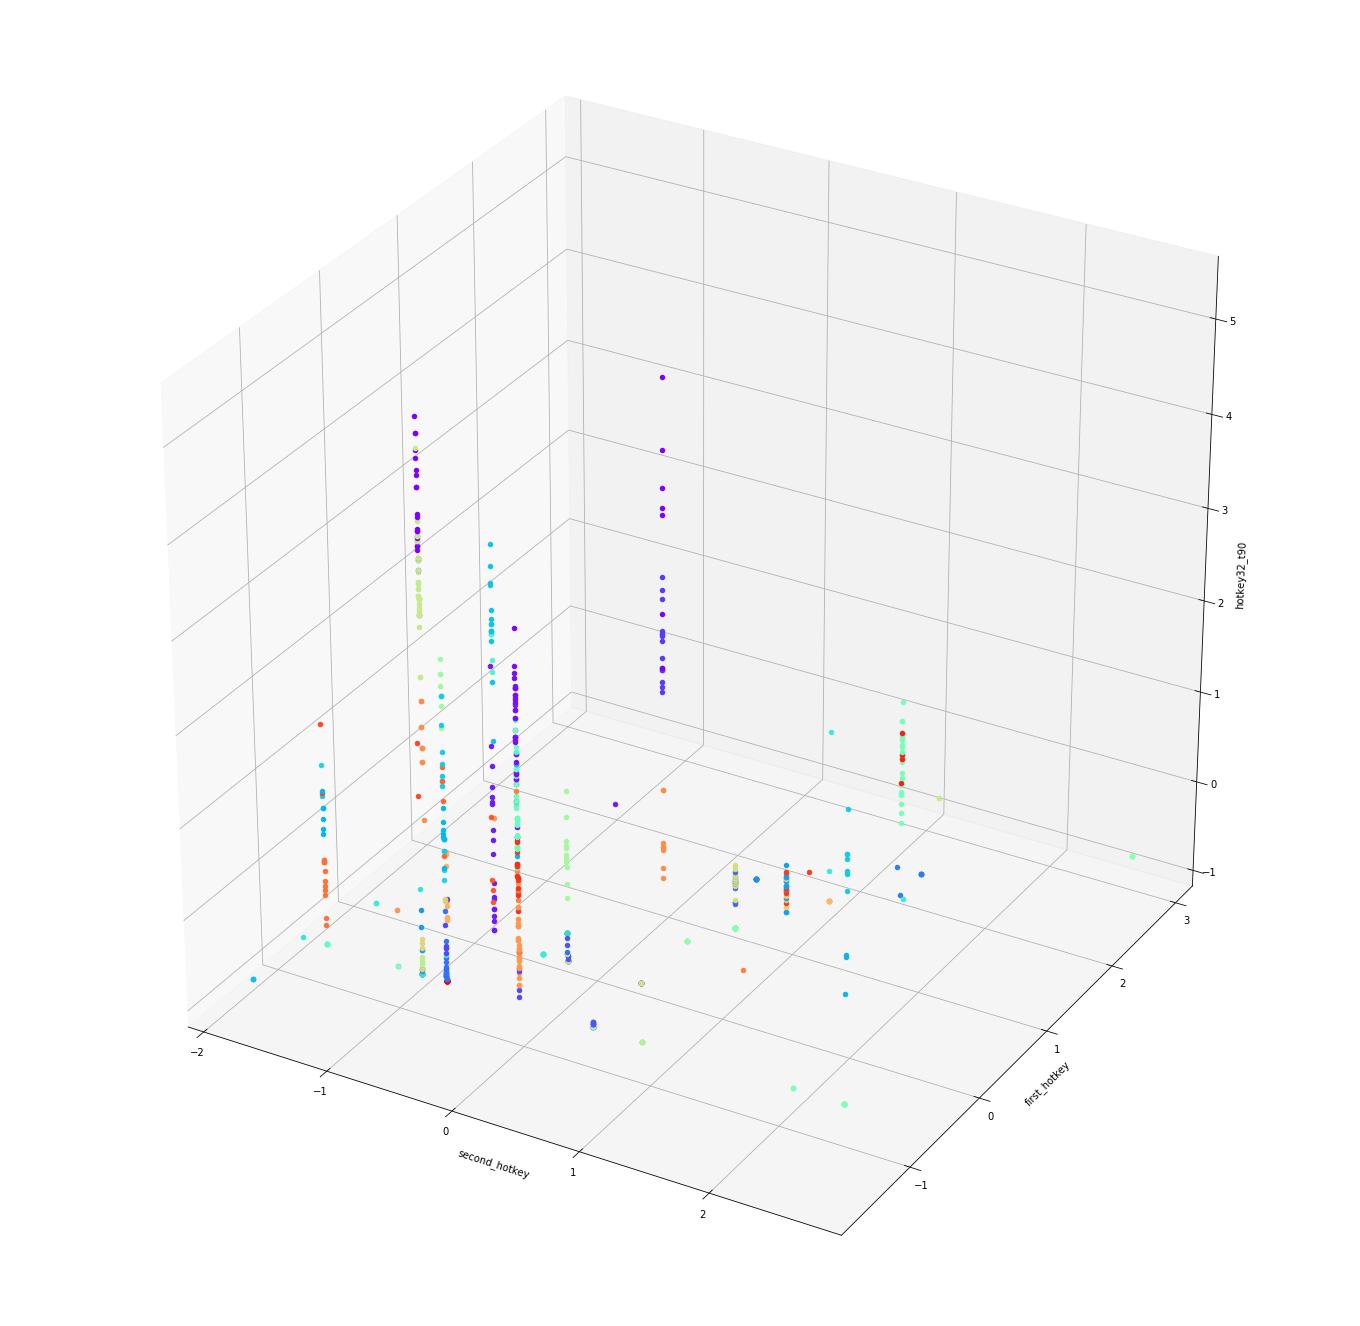

In [31]:
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('second_hotkey')
ax.set_ylabel('first_hotkey')
ax.set_zlabel('hotkey32_t90')

idx_race = 1
for player, race, x, y, z in zip(train_ids, races, x_feature, y_feature, z_feature): 
    if race == races_unique[idx_race]:
        ax.scatter(x, y, z, marker=race_symbols[race], color=ids_colors[player])
    
plt.show()

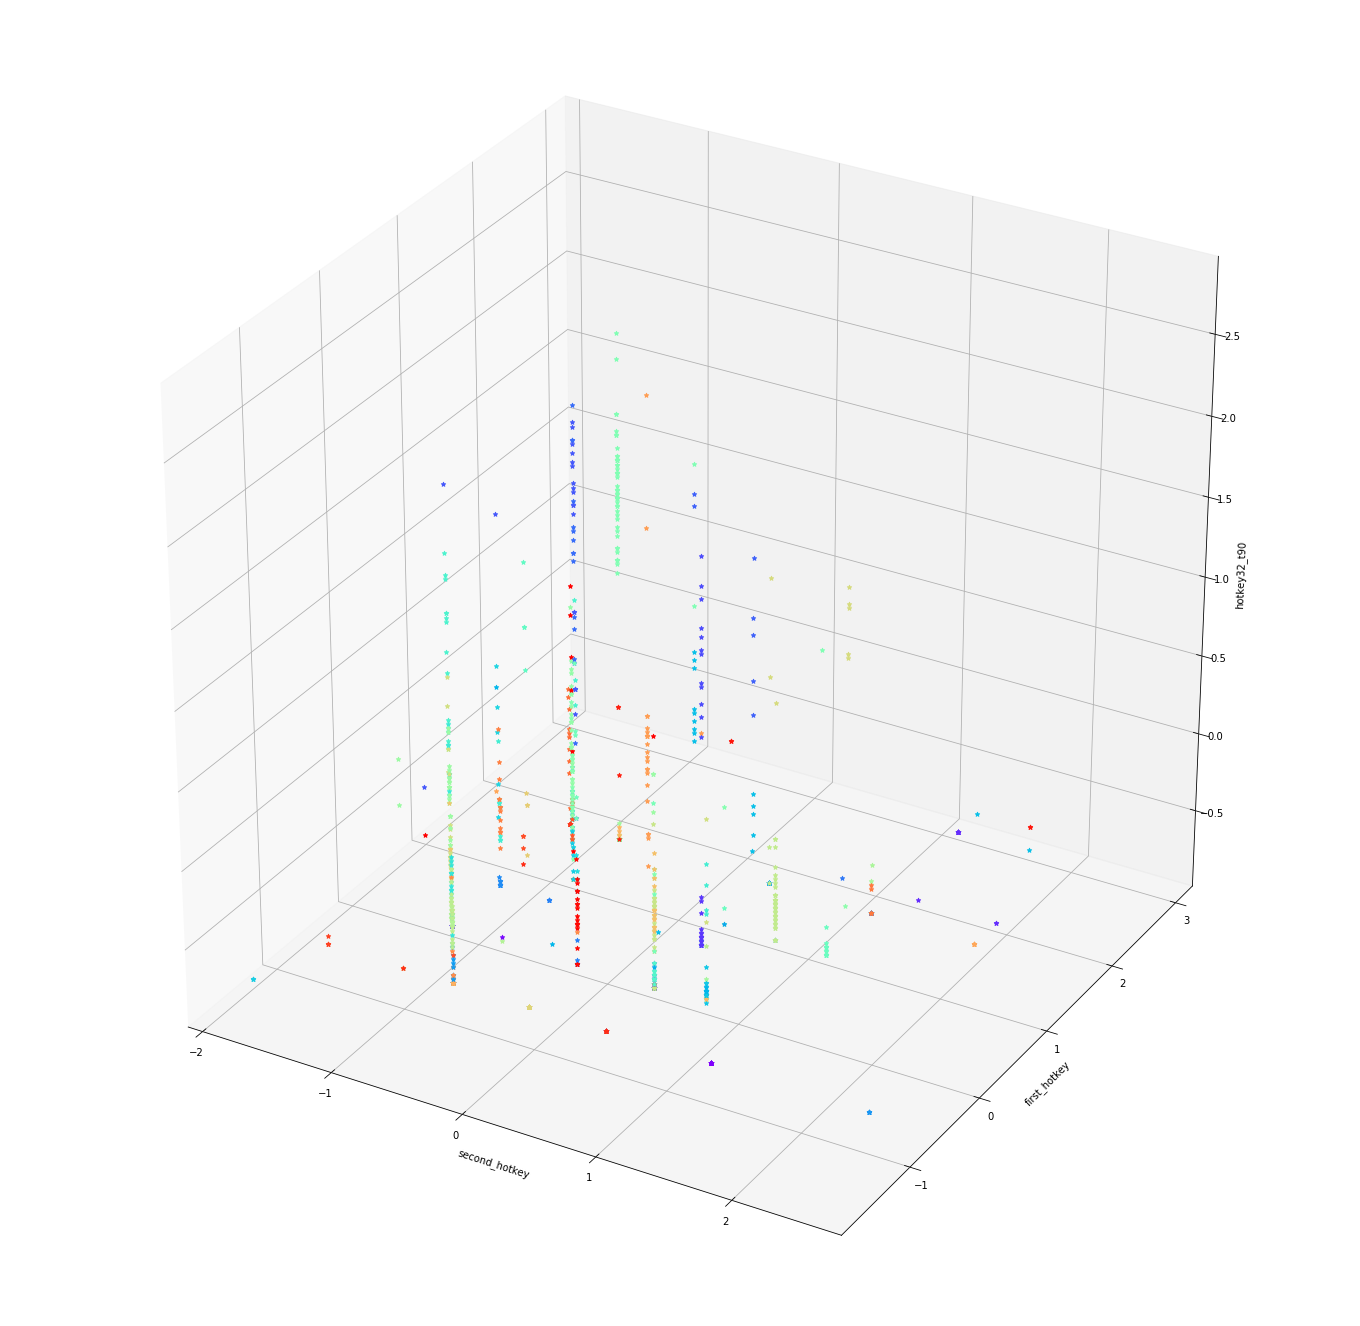

In [32]:
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('second_hotkey')
ax.set_ylabel('first_hotkey')
ax.set_zlabel('hotkey32_t90')
idx_race = 2
for player, race, x, y, z in zip(train_ids, races, x_feature, y_feature, z_feature): 
    if race == races_unique[idx_race]:
        ax.scatter(x, y, z, marker=race_symbols[race], color=ids_colors[player])
    
plt.show()

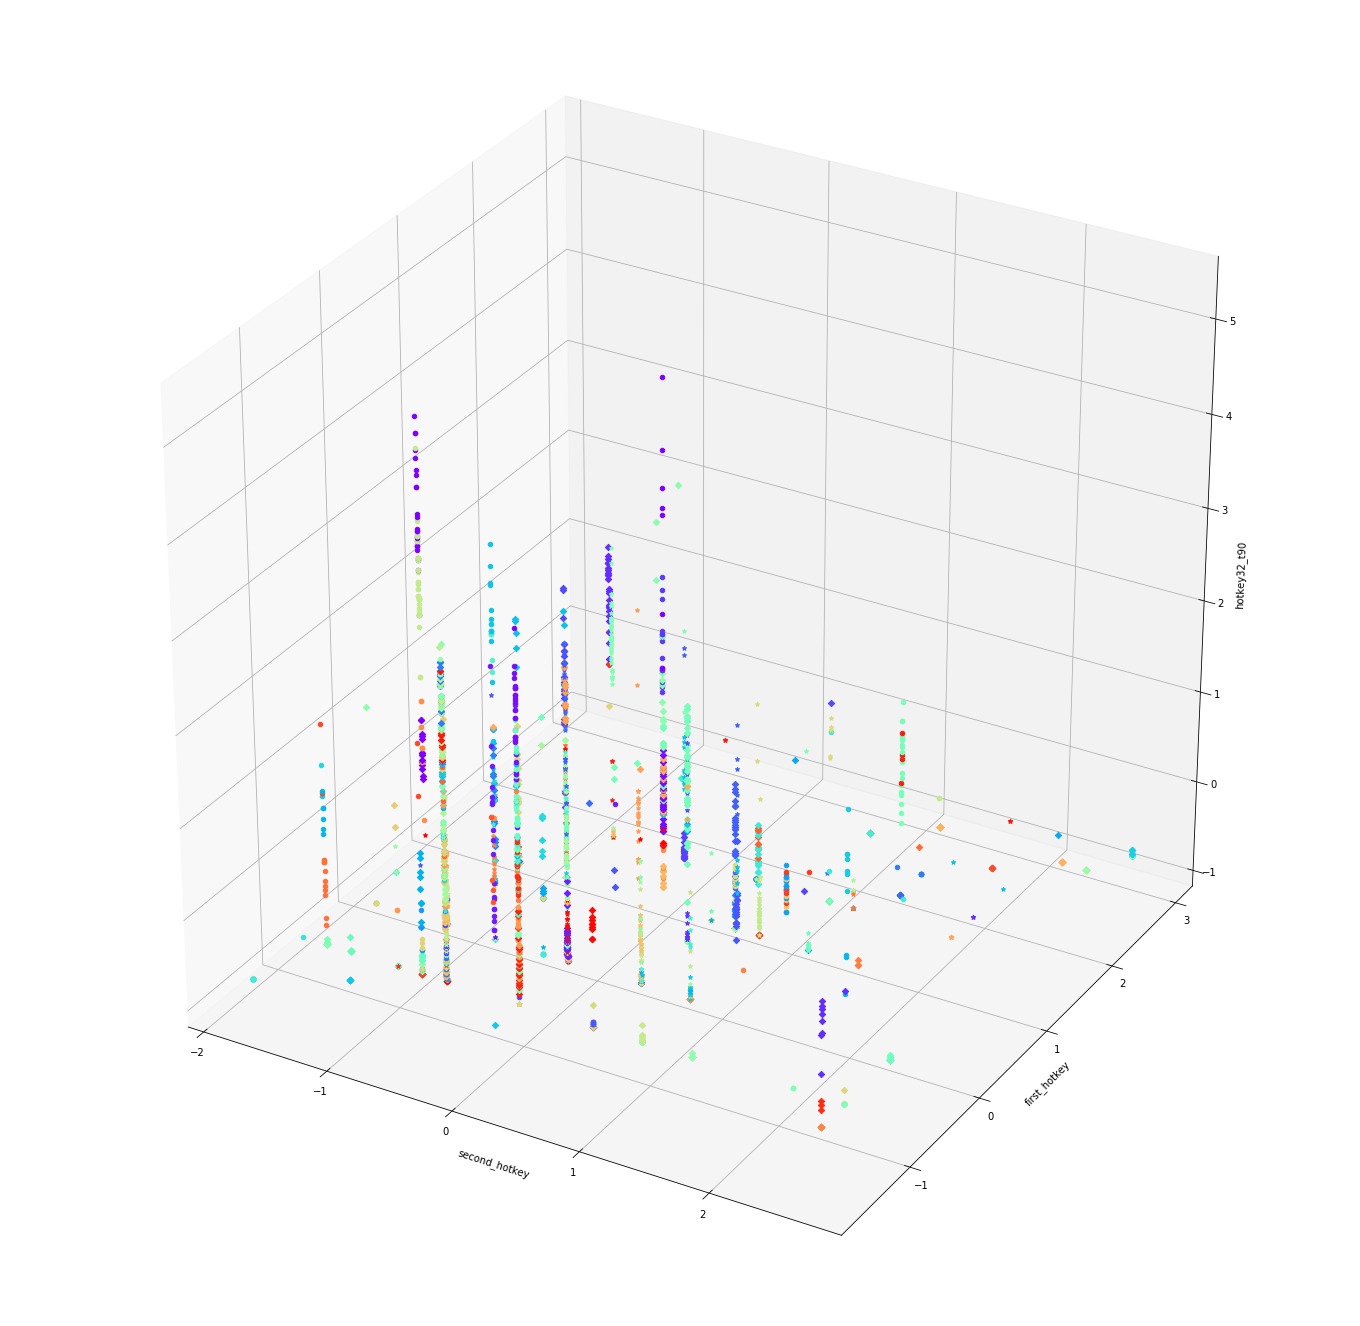

In [33]:
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('second_hotkey')
ax.set_ylabel('first_hotkey')
ax.set_zlabel('hotkey32_t90')
for player, race, x, y, z in zip(train_ids, races, x_feature, y_feature, z_feature): 
    ax.scatter(x, y, z, marker=race_symbols[race], color=ids_colors[player])
    
plt.show()

In [34]:
train_features = generate_features(train_data)
train_features = pd.get_dummies(train_features, columns = ['race']) # convert race to integers
for col in hotkey_columns:
    train_features[col] = le.fit_transform(train_features[col]) 
train_features.head()

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,...,second_hotkey,third_hotkey,fourth_hotkey,fifth_hotkey,sixth_hotkey,seventh_hotkey,eighth_hotkey,race_Protoss,race_Terran,race_Zerg
0,66,5,5,0,41,63,0,350,37,0,...,1,10,9,10,10,9,9,1,0,0
1,12,0,2,0,83,65,3,448,15,0,...,11,10,9,10,10,9,9,1,0,0
2,47,3,3,0,18,17,0,130,9,0,...,1,10,9,10,10,9,9,1,0,0
3,21,0,2,0,39,32,1,259,14,0,...,11,10,9,10,10,9,9,1,0,0
4,2,0,1,0,0,10,0,52,6,0,...,1,10,9,10,10,9,9,1,0,0


In [35]:
test_features = generate_features(test_data)
test_features = pd.get_dummies(test_features, columns = ['race']) # convert race to integers
for col in hotkey_columns:
    test_features[col] = le.fit_transform(test_features[col]) 

'''
# Get missing columns in the training test
missing_cols = set( train_features.columns ) - set( test_features.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_features[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_features = test_features[train_features.columns]
'''

test_features.head()

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,...,second_hotkey,third_hotkey,fourth_hotkey,fifth_hotkey,sixth_hotkey,seventh_hotkey,eighth_hotkey,race_Protoss,race_Terran,race_Zerg
0,19,3,14,0,847,7,31,352,10,0,...,15,1,21,3,2,16,3,0,0,1
1,0,0,2,0,33,14,0,336,31,0,...,1,10,9,9,8,9,9,0,1,0
2,20,0,1,0,0,10,0,479,53,0,...,9,15,10,20,16,16,16,1,0,0
3,17,2,0,0,0,68,89,525,13,6,...,11,7,12,11,10,11,7,0,0,1
4,21,0,3,0,0,4,7,74,8,0,...,9,11,14,14,12,13,14,1,0,0


## Predicting players

### Helper functions to save and check csv for submissions

In [36]:
def read_csv_head(path):
    with open(path, 'r') as f:
        c = 0
        for line in f:
            print(line)
            c+=1
            if c==10:
                break

def convert(output):
    output_df = pd.DataFrame(output, columns=['prediction'])
    output_df.index = range(1,len(output_df)+1)
    output_df.index.name = 'RowId'
    return output_df

def save(output_df, name):
    output_df.to_csv('./out_'+name+'.csv')

### First approach: Logistic regression

In [37]:
classifier = LogisticRegression(random_state=0, solver='liblinear', multi_class='auto', max_iter=2000)
classifier.fit(x_train,y_train)
y_predict = classifier.predict(x_test)
f1_score(y_test, y_predict, average='micro')

0.8766375545851528

In [38]:
classifier = LogisticRegression(random_state=0, solver='liblinear', multi_class='auto', max_iter=2000)
classifier.fit(train_features,train_ids)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
predicted_ids_lr = classifier.predict(test_features)
predicted_ids_lr_df = convert(predicted_ids_lr)
save(predicted_ids_lr_df, 'logisticregression')
predicted_ids_lr_df.head()

,prediction
RowId,
1,http://eu.battle.net/sc2/en/profile/3538115/1/Golden/
2,http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/
3,http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/
4,http://eu.battle.net/sc2/en/profile/250458/1/VortiX/
5,http://eu.battle.net/sc2/en/profile/950504/1/Grubby/


### Second approach: Decision Tree

In [40]:
classifier = DecisionTreeClassifier(min_samples_split=20, random_state=99)
classifier.fit(x_train,y_train)
y_predict = classifier.predict(x_test)
f1_score(y_test, y_predict, average='micro')

0.6550218340611353

In [41]:
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(train_features,train_ids)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [42]:
predicted_ids_dt = dt.predict(test_features)
predicted_ids_dt_df = convert(predicted_ids_dt)
save(predicted_ids_dt_df, 'decisiontree')
predicted_ids_dt_df.head()

,prediction
RowId,
1,http://eu.battle.net/sc2/en/profile/3538115/1/Golden/
2,http://kr.battle.net/sc2/en/profile/2343531/1/DREAM/
3,http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/
4,http://eu.battle.net/sc2/en/profile/250458/1/VortiX/
5,http://us.battle.net/sc2/en/profile/4352638/1/Tassadar/


Number of differences between Decision Tree and Logistic Regression

In [43]:
len(predicted_ids_dt_df)-len(set(predicted_ids_dt_df['prediction']).intersection(set(predicted_ids_lr_df['prediction'])))

214

In [44]:
len(predicted_ids_dt_df)

340

### Third approach: Random Forest

In [45]:
classifier = RandomForestClassifier(random_state=13, n_estimators=500)
classifier.fit(x_train,y_train)
y_predict = classifier.predict(x_test)
f1_score(y_test, y_predict, average='micro')

0.9093886462882096

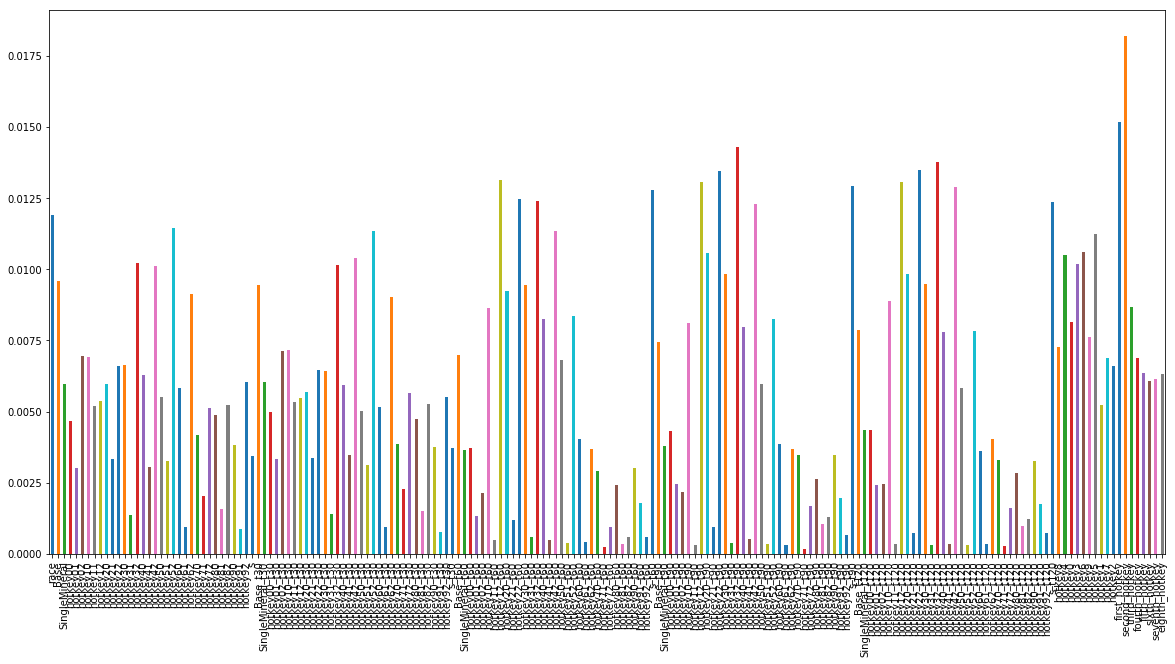

In [46]:
features_importance = pd.Series(classifier.feature_importances_)
features_importance.index = x_train.columns
features_importance.plot.bar(figsize=(20,10))

In [47]:
features_importance.sort_values()[::-1]

second_hotkey    0.018190
first_hotkey     0.015180
hotkey32_t90     0.014305
hotkey32_t120    0.013773
hotkey22_t120    0.013504
hotkey22_t90     0.013443
hotkey12_t60     0.013144
hotkey12_t120    0.013079
hotkey12_t90     0.013067
s_t90            0.012931
hotkey42_t120    0.012888
s_t60            0.012800
hotkey22_t60     0.012487
hotkey32_t60     0.012399
s_t120           0.012350
hotkey42_t90     0.012288
race             0.011906
hotkey52         0.011458
hotkey52_t30     0.011346
hotkey42_t60     0.011332
hotkey5          0.011241
hotkey6          0.010615
hotkey20_t90     0.010582
hotkey4          0.010486
hotkey42_t30     0.010412
hotkey32         0.010217
hotkey3          0.010175
hotkey32_t30     0.010141
hotkey42         0.010104
hotkey30_t90     0.009852
                   ...   
hotkey61_t30     0.000958
hotkey21_t90     0.000934
hotkey61         0.000933
hotkey72_t60     0.000929
hotkey91         0.000873
hotkey91_t30     0.000754
hotkey92_t120    0.000721
hotkey21_t12

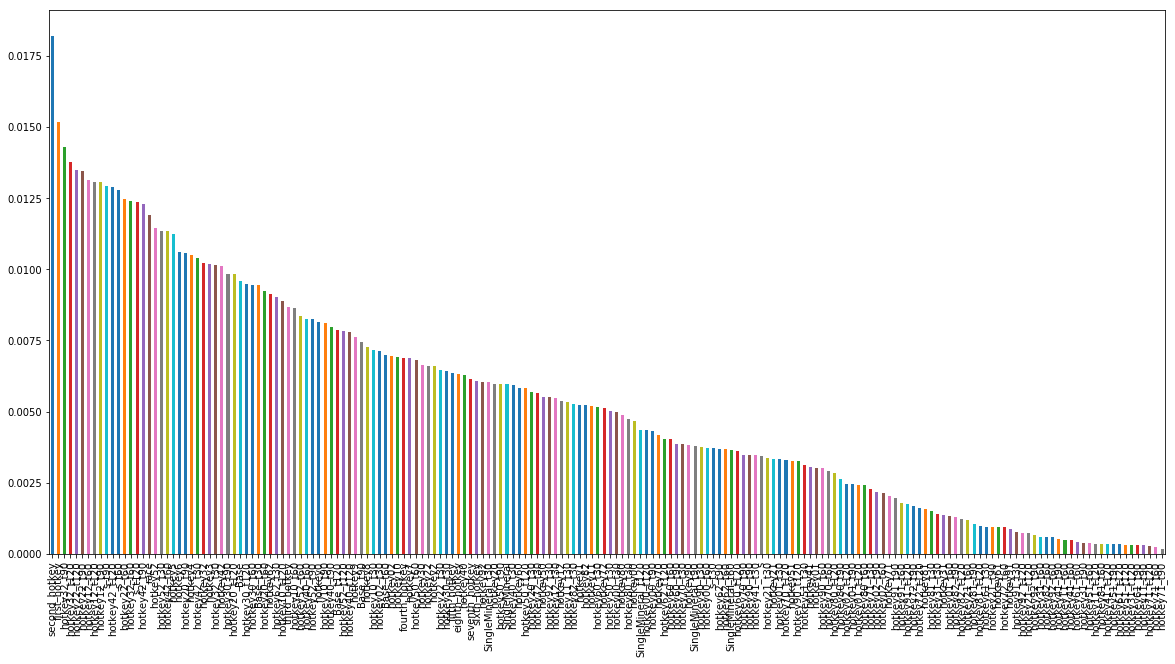

In [48]:
features_importance.sort_values()[::-1].plot.bar(figsize=(20,10))

In [49]:
rf = RandomForestClassifier(random_state=13, n_estimators=500)
rf.fit(train_features,train_ids)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [50]:
predicted_ids_rf = rf.predict(test_features)
predicted_ids_rf_df = convert(predicted_ids_rf)
save(predicted_ids_rf_df, 'randomforest')
predicted_ids_rf_df.head()

,prediction
RowId,
1,http://eu.battle.net/sc2/en/profile/3538115/1/Golden/
2,http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/
3,http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/
4,http://eu.battle.net/sc2/en/profile/250458/1/VortiX/
5,http://eu.battle.net/sc2/en/profile/950504/1/Grubby/


Number of differences between Decision Tree and Random Forest

In [51]:
len(predicted_ids_rf_df)-len(set(predicted_ids_rf_df['prediction']).intersection(set(predicted_ids_dt_df['prediction'])))

205

In [52]:
len(predicted_ids_rf_df)

340